In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [7]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, sparse=None, rho=1., optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.sparse = sparse
        self.rho = rho
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        
        if self.sparse == 'KL':
            self.latent_fn = nn.Sigmoid()
        else:
            self.latent_fn = nn.Tanh()
            
        self.fce = FullyConnected([32*2*2, 32])
        self.fcd = FullyConnected([32, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        self.h = self.latent_fn(self.fce(flatten))
        return self.h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
        
    def forward(self, x):
        h = self.encode(x)
        x = self.decode(h)
        return x
    
    def loss(self, output, target):
        if self.sparse == 'KL':
            h_mean = self.h.mean(0)
            sparse_loss = - torch.log(h_mean) * self.rho - torch.log(1-h_mean) * (1-self.rho)
            self.sparse_loss = sparse_loss.mean()
        elif self.sparse == 'L1':
            h_abs = torch.abs(self.h)
            self.sparse_loss = self.rho*h_abs.mean()
        else:
            self.sparse_loss = 0.
            
        self._loss = F.mse_loss(output, target) + self.sparse_loss
        
        return self._loss

In [8]:
# models = {'SGD': Net(False, False, 'SGD', lr=1e-4),
#           'momentum': Net(False, False, 'SGD', lr=1e-4, momentum=0.9),
#           'RMSProp': Net(False, False, 'RMSProp', lr=1e-4),
#           'RMSProp+bn': Net(True, False, 'RMSProp', lr=1e-4),
#           'Adam': Net(False, False, 'Adam', lr=1e-4), 
#           'Adam+bn': Net(True, False, 'Adam', lr=1e-4), 
#          }

models = {'Adam KL': Net(False, False, sparse='KL', rho=0.2, optim_type='Adam', lr=1e-4),
          'Adam L1': Net(False, False, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [10]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data).item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}'.format(k, test_loss[k]) for k in test_loss])
    if log is not None:
        for k in models:
            log[k].append((test_loss[k],))
    print(report)

In [11]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam KL: 0.7859 Adam L1: 0.1169
Train Epoch: 1 [10000/50000 (20%)]	Losses Adam KL: 0.5731 Adam L1: 0.0703
Train Epoch: 1 [20000/50000 (40%)]	Losses Adam KL: 0.5715 Adam L1: 0.0624
Train Epoch: 1 [30000/50000 (60%)]	Losses Adam KL: 0.5661 Adam L1: 0.0484
Train Epoch: 1 [40000/50000 (80%)]	Losses Adam KL: 0.5660 Adam L1: 0.0411
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam KL: 0.5677 Adam L1: 0.0358
Test losses: Adam KL: 0.5677 Adam L1: 0.0360
Train Epoch: 2 [0/50000 (0%)]	Losses Adam KL: 0.5716 Adam L1: 0.0377
Train Epoch: 2 [10000/50000 (20%)]	Losses Adam KL: 0.5659 Adam L1: 0.0331
Train Epoch: 2 [20000/50000 (40%)]	Losses Adam KL: 0.5677 Adam L1: 0.0289
Train Epoch: 2 [30000/50000 (60%)]	Losses Adam KL: 0.5662 Adam L1: 0.0270
Train Epoch: 2 [40000/50000 (80%)]	Losses Adam KL: 0.5691 Adam L1: 0.0263
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam KL: 0.5646 Adam L1: 0.0224
Test losses: Adam KL: 0.5661 Adam L1: 0.0227
Train Epoch: 3 [0/50000 (0%)]	

Test losses: Adam KL: 0.5132 Adam L1: 0.0077
Train Epoch: 18 [0/50000 (0%)]	Losses Adam KL: 0.5117 Adam L1: 0.0068
Train Epoch: 18 [10000/50000 (20%)]	Losses Adam KL: 0.5136 Adam L1: 0.0080
Train Epoch: 18 [20000/50000 (40%)]	Losses Adam KL: 0.5114 Adam L1: 0.0061
Train Epoch: 18 [30000/50000 (60%)]	Losses Adam KL: 0.5139 Adam L1: 0.0083
Train Epoch: 18 [40000/50000 (80%)]	Losses Adam KL: 0.5142 Adam L1: 0.0086
Train Epoch: 18 [50000/50000 (100%)]	Losses Adam KL: 0.5131 Adam L1: 0.0082
Test losses: Adam KL: 0.5129 Adam L1: 0.0076
Train Epoch: 19 [0/50000 (0%)]	Losses Adam KL: 0.5120 Adam L1: 0.0073
Train Epoch: 19 [10000/50000 (20%)]	Losses Adam KL: 0.5138 Adam L1: 0.0083
Train Epoch: 19 [20000/50000 (40%)]	Losses Adam KL: 0.5131 Adam L1: 0.0081
Train Epoch: 19 [30000/50000 (60%)]	Losses Adam KL: 0.5130 Adam L1: 0.0081
Train Epoch: 19 [40000/50000 (80%)]	Losses Adam KL: 0.5121 Adam L1: 0.0068
Train Epoch: 19 [50000/50000 (100%)]	Losses Adam KL: 0.5112 Adam L1: 0.0068
Test losses: Adam 

In [25]:
data, _ = next(iter(test_loader))
output = models['Adam KL'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['Adam KL'].decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['Adam KL'].encode(data)
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = models['Adam KL'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 13,  16,   7,  19,  14,  11,  14,  15,  19,  18,  16,  10,
         16,  15,   8,  17,  12,  14,  21,   8,  23,   8,  13,  11,
         12,  23,  10,  16,  21,  12,  15,   9,  20,  18,  20,  12,
         16,  10,  13,  12,   8,  16,  13,  13,  14,  11,  12,  10,
         22,  15])


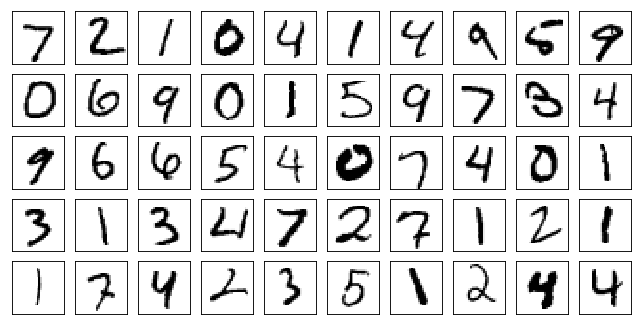

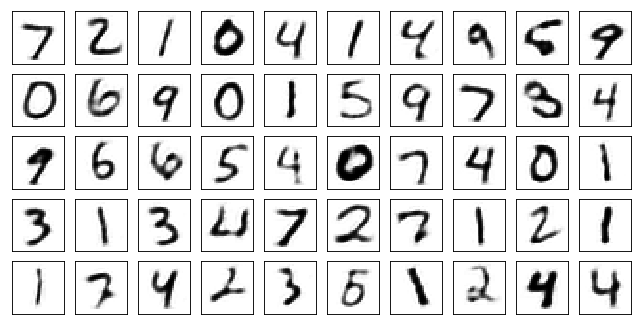

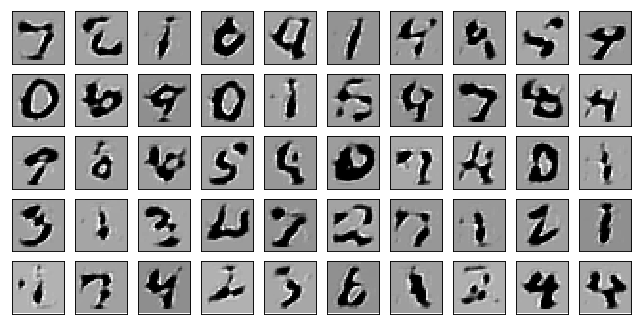

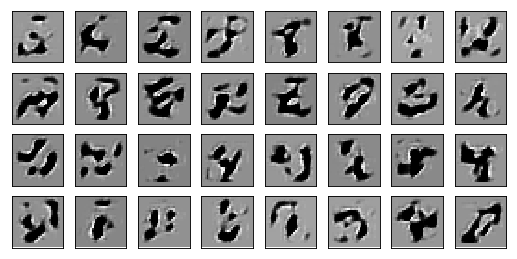

In [26]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8)) 

In [28]:
output = models['Adam L1'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['Adam L1'].decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['Adam L1'].encode(data)
    print((np.abs(encoded) > 0.05).sum(1))
    encoded[np.abs(encoded) < 0.05] = 0.
    decoded_f = models['Adam L1'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 10,  15,   9,  15,   9,   9,  17,  17,  17,  12,  12,  18,
          9,  11,   9,  16,  11,  11,  19,  11,  11,  12,  15,  13,
         12,  20,  15,  16,  12,  10,  14,  12,  11,  18,  13,  16,
         14,   8,  14,   9,  12,  12,  12,  18,  13,  11,  17,  13,
         13,  13])


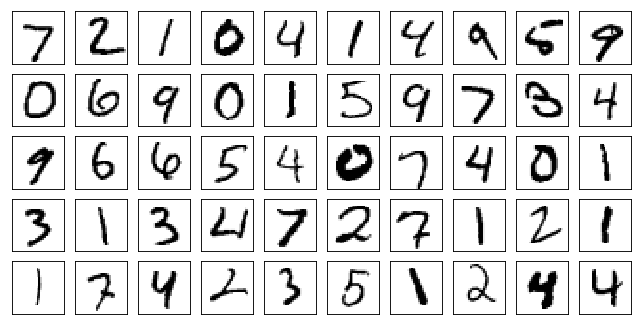

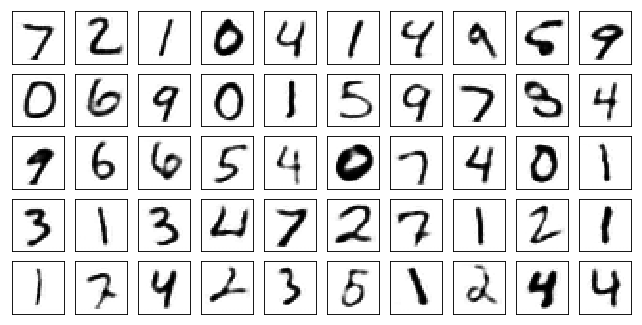

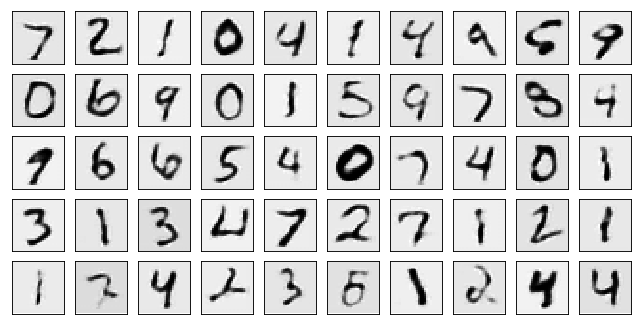

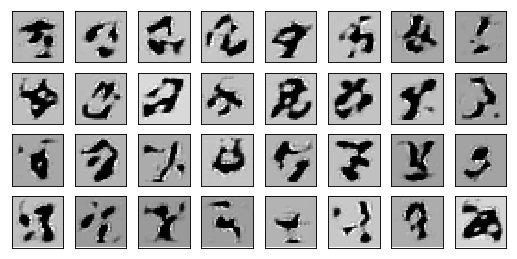

In [29]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8)) 

In [99]:
img_w = nn.Parameter(torch.Tensor(size=[32, 1, 28, 28]))
img_optim = optim.Adam(params=[img_w], lr=1e-4)

In [100]:
target = torch.eye(32)

In [101]:
for i in range(10000):
    img_optim.zero_grad()
    img = F.sigmoid(img_w)
    latent = models['Adam L1'].encode(img)
    loss = F.mse_loss(latent, target)
    loss.backward()
    img_optim.step()
    if i%1000 == 0:
        print(loss.item())

0.042666323482990265
0.040144115686416626
0.03771055489778519
0.03542408347129822
0.03331843391060829
0.0313543863594532
0.029530119150877
0.027854174375534058
0.026324251666665077
0.02492363005876541


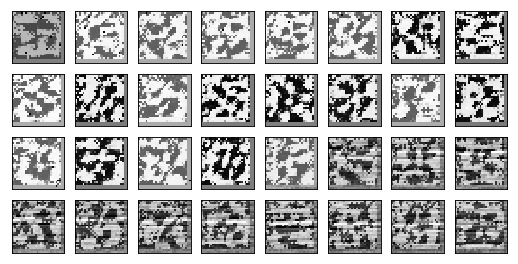

In [102]:
img = F.sigmoid(img_w)
plot_mnist(img.detach().numpy(), (4, 8)) 

In [103]:
img_w = nn.Parameter(torch.Tensor(size=[32, 1, 18, 18]))
img_optim = optim.Adam(params=[img_w], lr=1e-2)
target = torch.eye(32)

In [104]:
for i in range(10000):
    img_optim.zero_grad()
    img = F.sigmoid(img_w)
    latent, _, _ = models['Adam L1'].conv(img)
    loss = F.mse_loss(latent.view(32, 32), target)
    loss.backward()
    img_optim.step()
    if i%1000 == 0:
        print(loss.item())

0.05248939245939255
0.0241472739726305
0.023414362221956253
0.0232236385345459
0.023130472749471664
0.02309454418718815
0.02307070605456829
0.023059405386447906
0.02304999902844429
0.02304590865969658


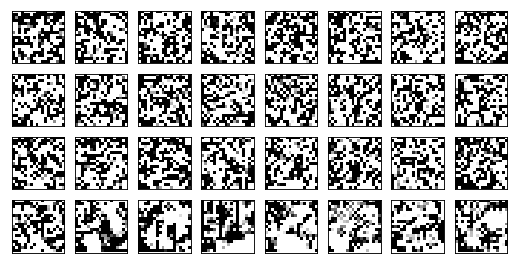

In [105]:
img = F.sigmoid(img_w)
plot_mnist(img.detach().numpy(), (4, 8)) 

In [106]:
img_w = nn.Parameter(torch.Tensor(size=[16, 1, 4, 4]))
img_optim = optim.Adam(params=[img_w], lr=1e-2)
target = torch.eye(16)

In [107]:
for i in range(10000):
    img_optim.zero_grad()
    img = F.sigmoid(img_w)
    latent = models['Adam L1']._conv1(img)
    loss = F.mse_loss(latent.view(16, 16), target)
    loss.backward()
    img_optim.step()
    if i%1000 == 0:
        print(loss.item())

0.13932016491889954
0.04718135669827461
0.04552530497312546
0.04511384665966034
0.044950295239686966
0.04487130045890808
0.04482915252447128
0.04480539262294769
0.04479162022471428
0.04478347301483154


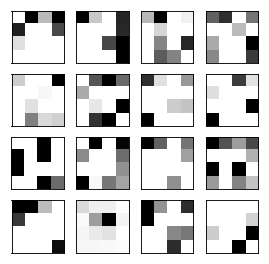

In [108]:
img = F.sigmoid(img_w)
plot_mnist(img.detach().numpy(), (4, 4)) 